In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

In [4]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

def abs_residual(params,data):
    x = data['x']
    y = data['y']
    x_and_y = np.vstack((x,y)).T
    t = np.array(data['t'])
    
    y0 = [x[0], y[0]]
    time = np.linspace(t[0],t[-1],len(t))
    model = odeint(lotka_volterra, y0, time, args=(params[0], params[1], params[2], params[3]))
    return np.linalg.norm(model - x_and_y)**2

In [115]:
def hill_climber(data, initial_params, step_size, iterations):
    best_params = initial_params
    prev_params = best_params*2
    best_loss = abs_residual(initial_params, data)
    
    while best_params.any != prev_params.any:
        prev_params = best_params
        print(f"prev: {prev_params}")
        for i in range(iterations):
            init_par = initial_params
            # Generate a random perturbation to the parameters
            perturbation = np.random.uniform(low=-step_size, high=step_size, size=len(initial_params))
            new_params = init_par + perturbation
            
            # Calculate the loss for the new parameters
            new_loss = abs_residual(new_params, data)
            
            # Update if the new parameters give a better loss
            if new_loss < best_loss:
                best_loss = new_loss
                best_params = new_params
    
    return best_params, best_loss

In [164]:
import random 
# init_guess = np.ones(4)
# print(init_guess)

init_guess = []
for i in range(4):
    init_guess.append(random.uniform(0, 1))
  
init_guess = np.array(init_guess)
print(init_guess)
min_function = abs_residual
step_size = 0.1
iterations = 10
data = df

params, loss = hill_climber(data, init_guess, step_size, iterations)

print(params, loss)

[0.73798689 0.41040537 0.20672803 0.20932976]
prev: [0.73798689 0.41040537 0.20672803 0.20932976]
prev: [0.75541571 0.49442545 0.12802198 0.1329851 ]
prev: [0.83568872 0.33196262 0.13933688 0.30003065]
[0.83568872 0.33196262 0.13933688 0.30003065] 848.7573993716424


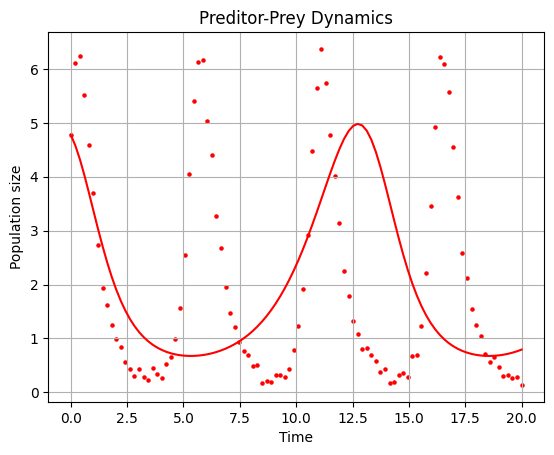

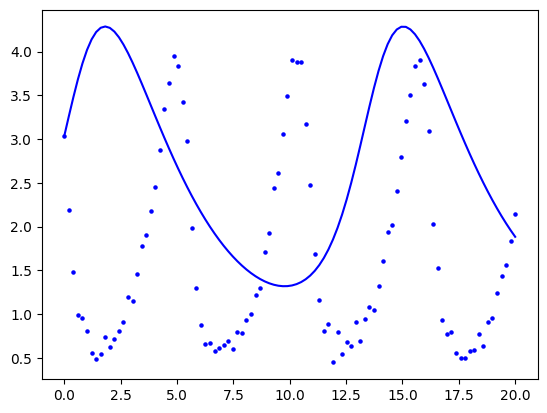

In [165]:
alpha_sim = params[0]
beta_sim = params[1]
delta_sim = params[2]
gamma_sim = params[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output = odeint(lotka_volterra, y0, t, args=(alpha_sim, beta_sim, delta_sim, gamma_sim))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()